In [9]:
%matplotlib inline

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms

import sys
REPO_PATH = '/proj/brizk/attention-target-detection'
sys.path.append(REPO_PATH)
from config import input_resolution, output_resolution
from utils import imutils, evaluation
from model import ModelSpatial
import torch

from scipy.misc import imresize
import matplotlib.pyplot as plt
import matplotlib.patches as patches


from dataset_loader import DatasetLoader, RetinafaceInferenceGenerator

def display_img(img):
    if isinstance(img, str):
        display_img(cv2.imread(img))
        return
    plt.figure(dpi=100)
    plt.imshow(np.array(img))
    # px.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).show()

In [10]:
home_dir = '/proj/brizk/output/'
faces_dir = os.path.join(*[home_dir, 'retinaface'])
faces_files = RetinafaceInferenceGenerator(faces_dir)
ds, filename = next(faces_files)
(faces_dir, ds, filename)

('/proj/brizk/output/retinaface', 'MS', '2017-03-08_IDMSSM55_BOSCC_vid.csv')

In [35]:
video_name = filename.split(".")[0]

column_names = ['frame', 'confidence', 'left', 'top', 'right', 'bottom']
   
df = pd.read_csv(
    os.path.join(*[faces_dir, ds, filename]),
    header=None, names=column_names, usecols=range(6)
)

df['left'] -= (df['right']-df['left'])*0.1
df['right'] += (df['right']-df['left'])*0.1
df['top'] -= (df['bottom']-df['top'])*0.1
df['bottom'] += (df['bottom']-df['top'])*0.1

df.head()

,frame,confidence,left,top,right,bottom
150,11690,0.993495,1396.91219,3.143831,1515.266041,199.103891
151,11700,0.994990,1062.27805,217.980884,1160.882765,336.465246
152,11700,0.987295,1310.86758,31.462155,1431.207162,223.228251
153,11710,0.992547,1056.66661,221.498563,1157.903559,339.770824
154,11710,0.936116,1217.95658,106.428120,1312.185572,247.957464


In [ ]:
df.loc[150:150+10].head()

In [12]:
videos_ds = DatasetLoader()
video = videos_ds[(ds, video_name)]

index 5824
current frame before query 0
trying to seek
queried frame_num 56850
current frame 56850
<class 'numpy.ndarray'>


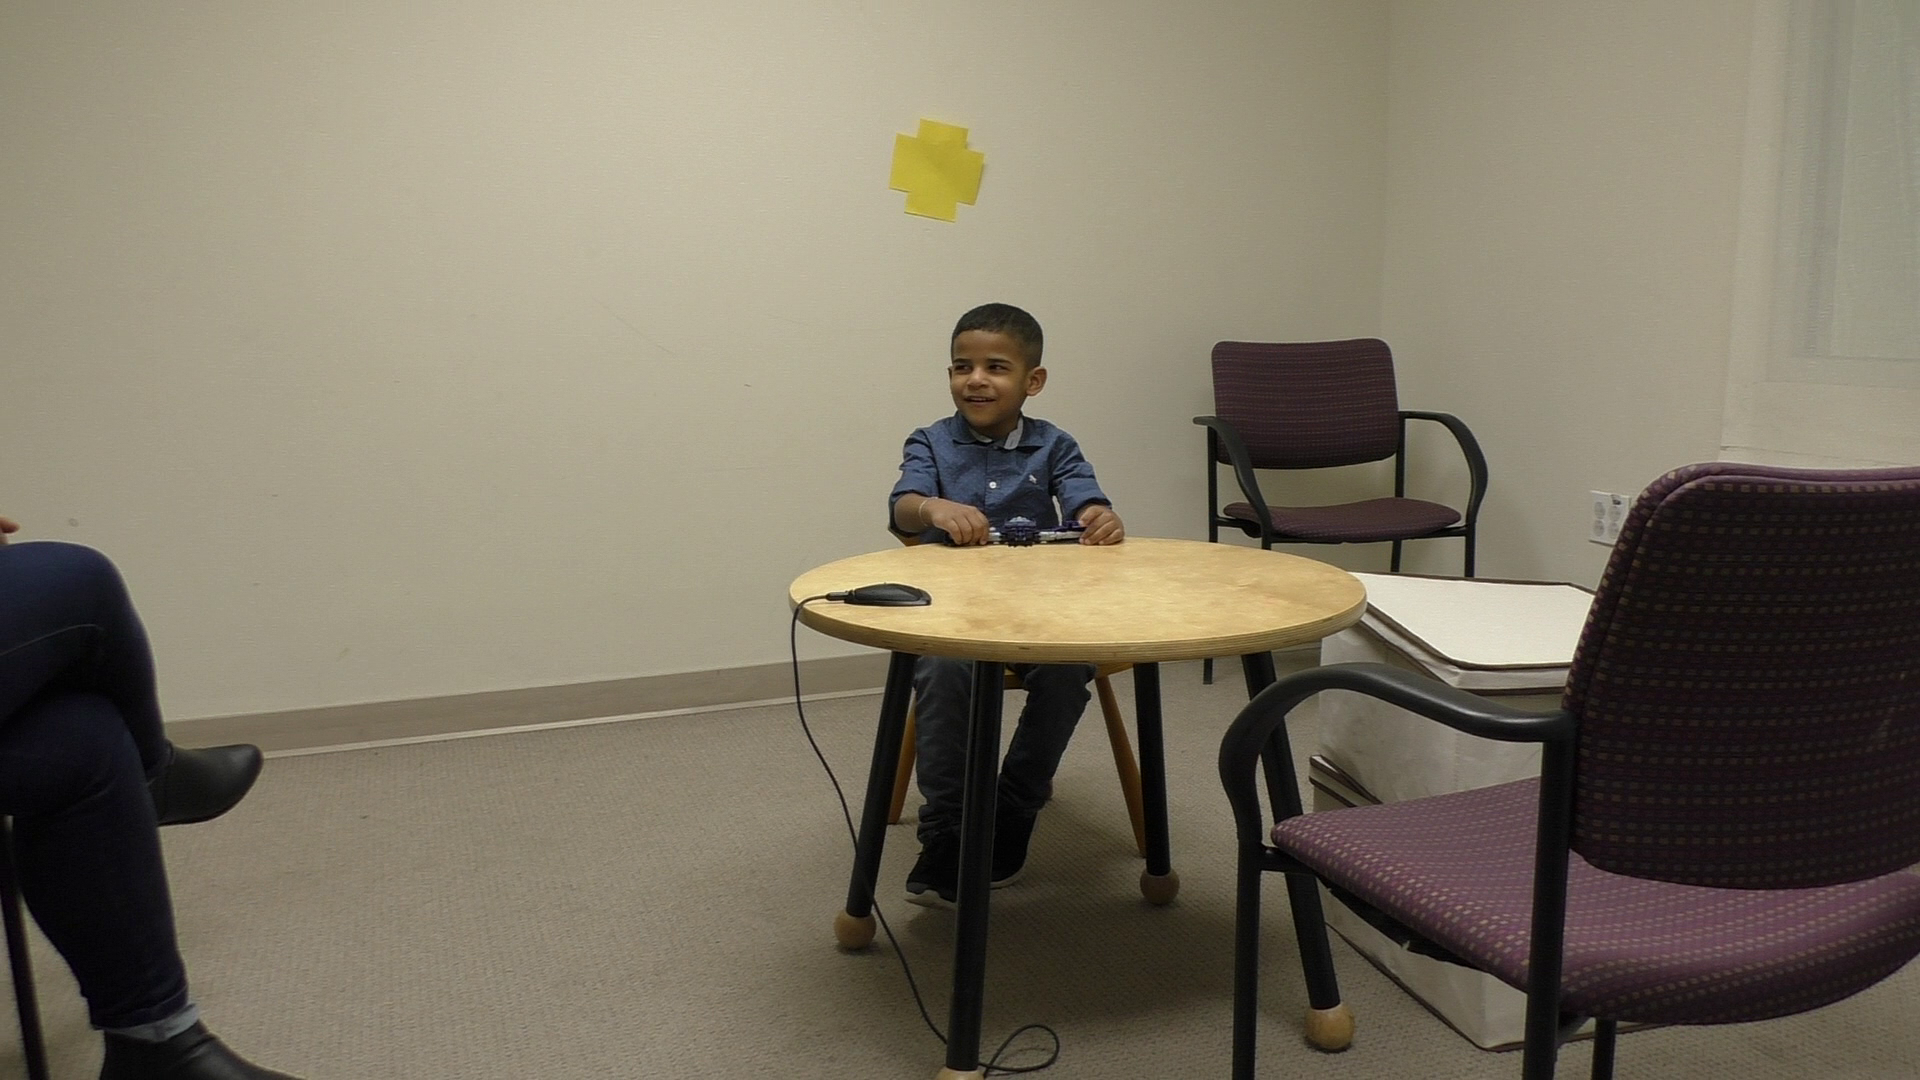

In [13]:
i = df.index[-1]
print('index', i)
print('current frame before query', video.current_frame_num)
frame_num = df.loc[i, 'frame']
frame_img = video[frame_num]
print('queried frame_num', frame_num)
print('current frame', video.current_frame_num)

assert frame_img is not None
print(type(frame_img))
frame_raw = Image.fromarray(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))
# frame_raw = Image.open(os.path.join(*[home_dir, 'imgs', 'MS' , video_name, str(frame_num) + ".jpg" ]))
width, height = frame_raw.size
frame_raw

In [14]:
def _get_transform():
    transform_list = []
    transform_list.append(transforms.Resize((input_resolution, input_resolution)))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return transforms.Compose(transform_list)

torch.Size([1, 3, 224, 224])


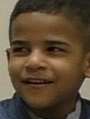

In [15]:
# set up data transformation
test_transforms = _get_transform()

head_box = np.array([df.loc[i,'left'], df.loc[i,'top'], df.loc[i,'right'], df.loc[i,'bottom']]).astype(np.int32)
head_img = frame_raw.crop((head_box)) # head crop
head = test_transforms(head_img) # transform inputs
frame = test_transforms(frame_raw)
head_channel = imutils.get_head_box_channel(head_box[0], head_box[1], head_box[2], head_box[3], width, height,
                                            resolution=input_resolution).unsqueeze(0)
head = head.unsqueeze(0).cuda()
frame = frame.unsqueeze(0).cuda()
head_channel = head_channel.unsqueeze(0).cuda()

print(head.shape)
head_img


In [16]:
model = ModelSpatial()
model_dict = model.state_dict()
pretrained_dict = torch.load(os.path.join(REPO_PATH, 'model_demo.pt'))
pretrained_dict = pretrained_dict['model']
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

model.cuda()
model.train(False)

ModelSpatial(
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (conv1_scene): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1_scene): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1_scene): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample):

In [29]:
with torch.no_grad():
    # forward pass
    raw_hm, _, inout = model(frame, head_channel, head)

    # # heatmap modulation
    raw_hm = raw_hm.cpu().detach().numpy() * 255
    raw_hm = raw_hm.squeeze()
    inout = inout.cpu().detach().numpy()
    inout = 1 / (1 + np.exp(-inout))
    inout = (1 - inout) * 255
    norm_map = imresize(raw_hm, (height, width)) - inout
    # pred_x, pred_y = evaluation.argmax_pts(raw_hm)
    # norm_p = [pred_x/output_resolution, pred_y/output_resolution]
    # observation_coordinates = tuple(map(int, (norm_p[0]*width, norm_p[1]*height)))

/home/brizk/.conda/envs/attention_target/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


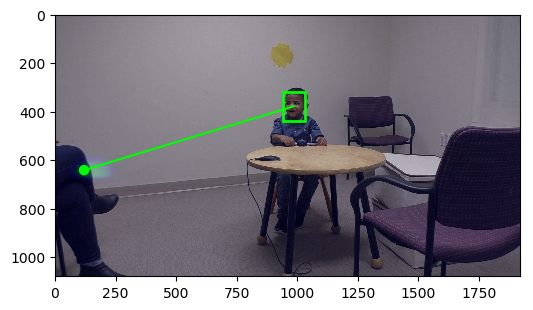

In [30]:
# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
# plt.margins(0,0)

plt.figure(dpi=100)
plt.imshow(frame_raw)
ax = plt.gca()
rect = patches.Rectangle((head_box[0], head_box[1]), head_box[2]-head_box[0], head_box[3]-head_box[1], linewidth=2, edgecolor=(0,1,0), facecolor='none')
ax.add_patch(rect)

# if args.vis_mode == 'arrow':
# if inout < args.out_threshold: # in-frame gaze
pred_x, pred_y = evaluation.argmax_pts(raw_hm)
norm_p = [pred_x/output_resolution, pred_y/output_resolution]
circ = patches.Circle((norm_p[0]*width, norm_p[1]*height), height/50.0, facecolor=(0,1,0), edgecolor='none')
ax.add_patch(circ)
plt.plot((norm_p[0]*width,(head_box[0]+head_box[2])/2), (norm_p[1]*height,(head_box[1]+head_box[3])/2), '-', color=(0,1,0,1))

# plt.savefig(str(i) + "_out.jpg", dpi=1200)

# else:

plt.imshow(norm_map, cmap = 'jet', alpha=0.2, vmin=0, vmax=255)


# plt.show(block=False)
# plt.pause(0.2)


Observation is at (120, 641)


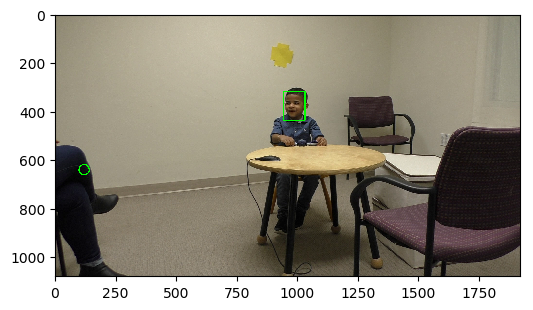

In [31]:
out_img = np.array(frame_raw)

cv2.rectangle(out_img, (head_box[0], head_box[1]), (head_box[2], head_box[3]), (0, 255, 0), 4)

pred_x, pred_y = evaluation.argmax_pts(raw_hm)
norm_p = [pred_x/output_resolution, pred_y/output_resolution]
observation_coordinates = tuple(map(int, (norm_p[0]*width, norm_p[1]*height)))
cv2.circle(out_img, observation_coordinates, int(height/50.0), (0, 255, 0), 4)

print('Observation is at', observation_coordinates)

display_img(out_img)
# cv2.applyColorMap(out_img, norm_map, cv2.COLORMAP_JET)

# norm_map[norm_map < 0] = 0
# cv2.addWeighted(out_img, 0.2, norm_map.astype(np.int32) , 0.1, 0)

# px.imshow(np.array(out_img)).show() 
# cv2.imwrite(str(frame_num) + "_out.jpg", cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))

In [32]:
o_x = observation_coordinates[0]
o_y = observation_coordinates[1]
print((o_y, o_x))
print(norm_map.shape)

step= 1
snippet = norm_map[o_y-step:o_y+step+1, o_x-step:o_x+step+1]
print(snippet.shape)
snippet

# NOTE!!!! I do not understand how come is the observation coordinates map to negative value in the norm_map
print(norm_map[o_y, o_x])

cv2.imwrite('heatmap_6.jpg', norm_map)

(641, 120)
(1080, 1920)
(3, 3)
81.28233


True

0 255
rect bounds 69 597 169 87


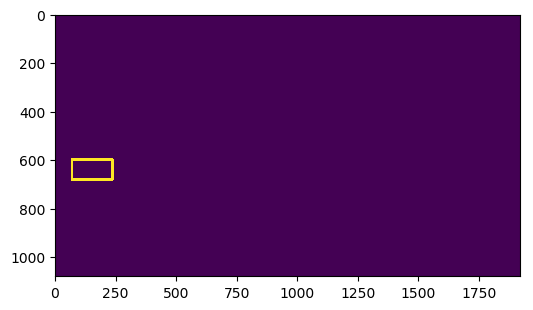

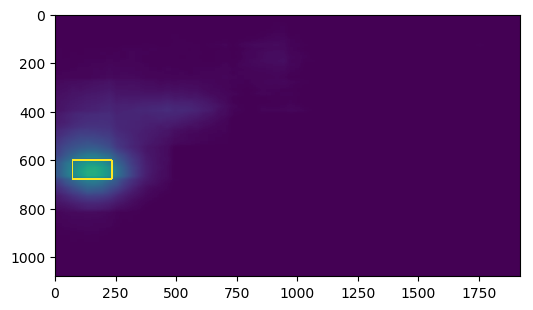

In [25]:
# Grayscale then Otsu's threshold
gray = norm_map.copy()
gray[gray < 0] = 0
gray = gray.astype(np.uint8)
print(np.min(gray), np.max(gray))
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(thresh, (x, y), (x + w, y + h), (255,255,255), 5)

print('rect bounds', x, y, w, h)
display_img(thresh)
display_img(norm_map)


In [33]:
## Here is the code to generate the bounding box from the heatmap
# 
# to reproduce the ILSVRC localization result, you need to first generate
# the heatmap for each testing image by merging the heatmap from the
# 10-crops (it is exactly what the demo code is doing), then resize the merged heatmap back to the original size of
# that image. Then use this bbox generator to generate the bbox from the resized heatmap.
#
# The source code of the bbox generator is also released. Probably you need
# to install the correct version of OpenCV to compile it.
#
# Special thanks to Hui Li for helping on this code.
#
# Bolei Zhou, April 19, 2016

import os
import numpy as np
import cv2

import sys
REPO_PATH = '/proj/rash/CAM-Python'
sys.path.append(REPO_PATH)

from py_map2jpg import py_map2jpg

def im2double(im):
	return cv2.normalize(im.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

bbox_threshold = [20, 100, 110] # parameters for the bbox generator
curParaThreshold = str(bbox_threshold[0])+' '+str(bbox_threshold[1])+' '+str(bbox_threshold[2])+' '
curHeatMapFile = 'heatmap_6.jpg'
curBBoxFile = 'heatmap_6.txt'

os.system(REPO_PATH + "/" + "bboxgenerator/./dt_box "+curHeatMapFile+' '+curParaThreshold+' '+curBBoxFile)

with open(curBBoxFile) as f:
	for line in f:
		items = [int(x) for x in line.strip().split()]

boxData1 = np.array(items[0::4]).T
boxData2 = np.array(items[1::4]).T
boxData3 = np.array(items[2::4]).T
boxData4 = np.array(items[3::4]).T

boxData_formulate = np.array([boxData1, boxData2, boxData1+boxData3, boxData2+boxData4]).T

col1 = np.min(np.array([boxData_formulate[:,0], boxData_formulate[:,2]]), axis=0)
col2 = np.min(np.array([boxData_formulate[:,1], boxData_formulate[:,3]]), axis=0)
col3 = np.max(np.array([boxData_formulate[:,0], boxData_formulate[:,2]]), axis=0)
col4 = np.max(np.array([boxData_formulate[:,1], boxData_formulate[:,3]]), axis=0)

boxData_formulate = np.array([col1, col2, col3, col4]).T

curHeatMap = cv2.imread(curHeatMapFile)
curImg = frame_img

curHeatMap = im2double(curHeatMap)
curHeatMap = py_map2jpg(curHeatMap, None, 'jet')
curHeatMap = im2double(curImg)*0.2+im2double(curHeatMap)*0.7

[ 60 590]
[242 685]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


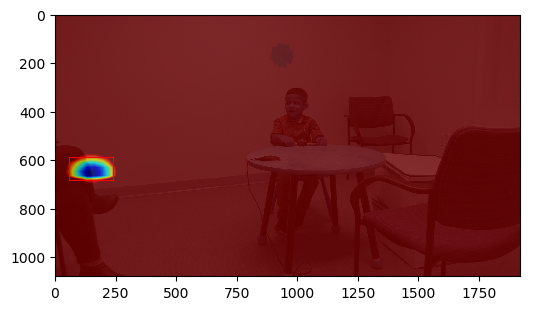

In [34]:
for i in range(boxData_formulate.shape[0]): # for each bbox
	print(boxData_formulate[i][:2])
	print(boxData_formulate[i][2:])
	cv2.rectangle(curHeatMap, tuple(boxData_formulate[i][:2]), tuple(boxData_formulate[i][2:]), (255,0,0), 3)
	display_img(curHeatMap)

In [ ]:
import pickle
src_dir = '/proj/brizk/output/attentiontarget/MS/2016-09-16_IDMSSM28_BOSCC_vid.pkl'
with open(src_dir, 'rb') as f:    
    attention_target_obj = pickle.load(f)   
    
observation_coordinates = attention_target_obj[0]['observation_coordinates']
raw_hm = attention_target_obj[0]['raw_hm']
norm_map = imresize(raw_hm, (height, width)) - inout

In [ ]:
out_img = np.array(frame_raw)
cv2.rectangle(out_img, (head_box[0], head_box[1]), (head_box[2], head_box[3]), (0, 255, 0), 4)
cv2.circle(out_img, observation_coordinates, int(height/50.0), (0, 255, 0), 4)
print('Observation is at', observation_coordinates)

display_img(out_img)

In [ ]:

plt.figure(dpi=100)
plt.imshow(frame_raw)
ax = plt.gca()
rect = patches.Rectangle((head_box[0], head_box[1]), head_box[2]-head_box[0], head_box[3]-head_box[1], linewidth=2, edgecolor=(0,1,0), facecolor='none')
ax.add_patch(rect)

circ = patches.Circle((observation_coordinates[0], observation_coordinates[1]), height/50.0, facecolor=(0,1,0), edgecolor='none')
ax.add_patch(circ)
plt.plot((observation_coordinates[0],(head_box[0]+head_box[2])/2), (observation_coordinates[1],(head_box[1]+head_box[3])/2), '-', color=(0,1,0,1))

plt.imshow(norm_map, cmap = 'jet', alpha=0.2, vmin=0, vmax=255)
